In [ ]:
# import library and data
import pandas as pd
import numpy as np
import os

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
from statsmodels.tsa.stattools import adfuller 
from statsmodels.stats.diagnostic import acorr_ljungbox  
from statsmodels.tsa.arima_model import ARMA 
from statsmodels.api import OLS, add_constant

import matplotlib.pyplot as plt
import seaborn as sns

# Granger Causality Test Built in Python
from statsmodels.tsa.stattools import grangercausalitytests

In [45]:
def std(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

def load_sentiment_data(data_path='./statistical_analysis_data',
                       na_option='drop'):
    loaded_data = {}
    
    all_files = os.listdir(data_path)
    for file in all_files:
        df = pd.read_excel(data_path+'/'+file)
        df.set_index('Date', inplace=True)
        if na_option == 'zero':
            df = df.iloc[1:, :].fillna(0) # drop fisrt obs, fill na as 0
        elif na_option == 'drop':
            df = df.iloc[1:, :].dropna()
            if len(df) == 0: 
                print('No observations for: ', file.split(".")[0])
        # add a column of sentiment difference
        df['sentiment_df'] = np.nan_to_num(df['senti_rela_score'] - \
                             df['senti_rela_score'].shift(1))
        # add a column of standarized sentiment
        df['senti_rela_std'] = std(df['senti_rela_score'])
        df['volume_std'] = std(df['Volume'])
        
        
        loaded_data[file.split(".")[0]] = df
    return loaded_data

sentiment_data = load_sentiment_data()
sentiment_data

{'ALGN':                      Last Price  Volume  log_return  excess_log_return  \
 Date                                                                     
 2020-11-30 11:30:00    477.3900    3100    0.002202           0.005062   
 2020-11-30 14:30:00    477.1300     300   -0.005122          -0.006063   
 2020-12-01 09:30:00    487.3100   27392    0.022181           0.012629   
 2020-12-01 12:30:00    501.5600    4225   -0.010492          -0.010356   
 2020-12-01 14:30:00    499.9075    5867   -0.004058          -0.004030   
 2020-12-01 15:30:00    499.1100    9024   -0.001597           0.001378   
 2020-12-02 09:30:00    494.8050    6837   -0.008663          -0.004775   
 2020-12-02 13:30:00    503.1600    2541   -0.001291          -0.000963   
 2020-12-03 09:30:00    510.0000   15654    0.009456           0.008311   
 2020-12-03 10:30:00    509.3450    7233   -0.001285          -0.003544   
 2020-12-04 09:30:00    514.2500    6626    0.001966           0.002252   
 2020-12-04 15:30

D:\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


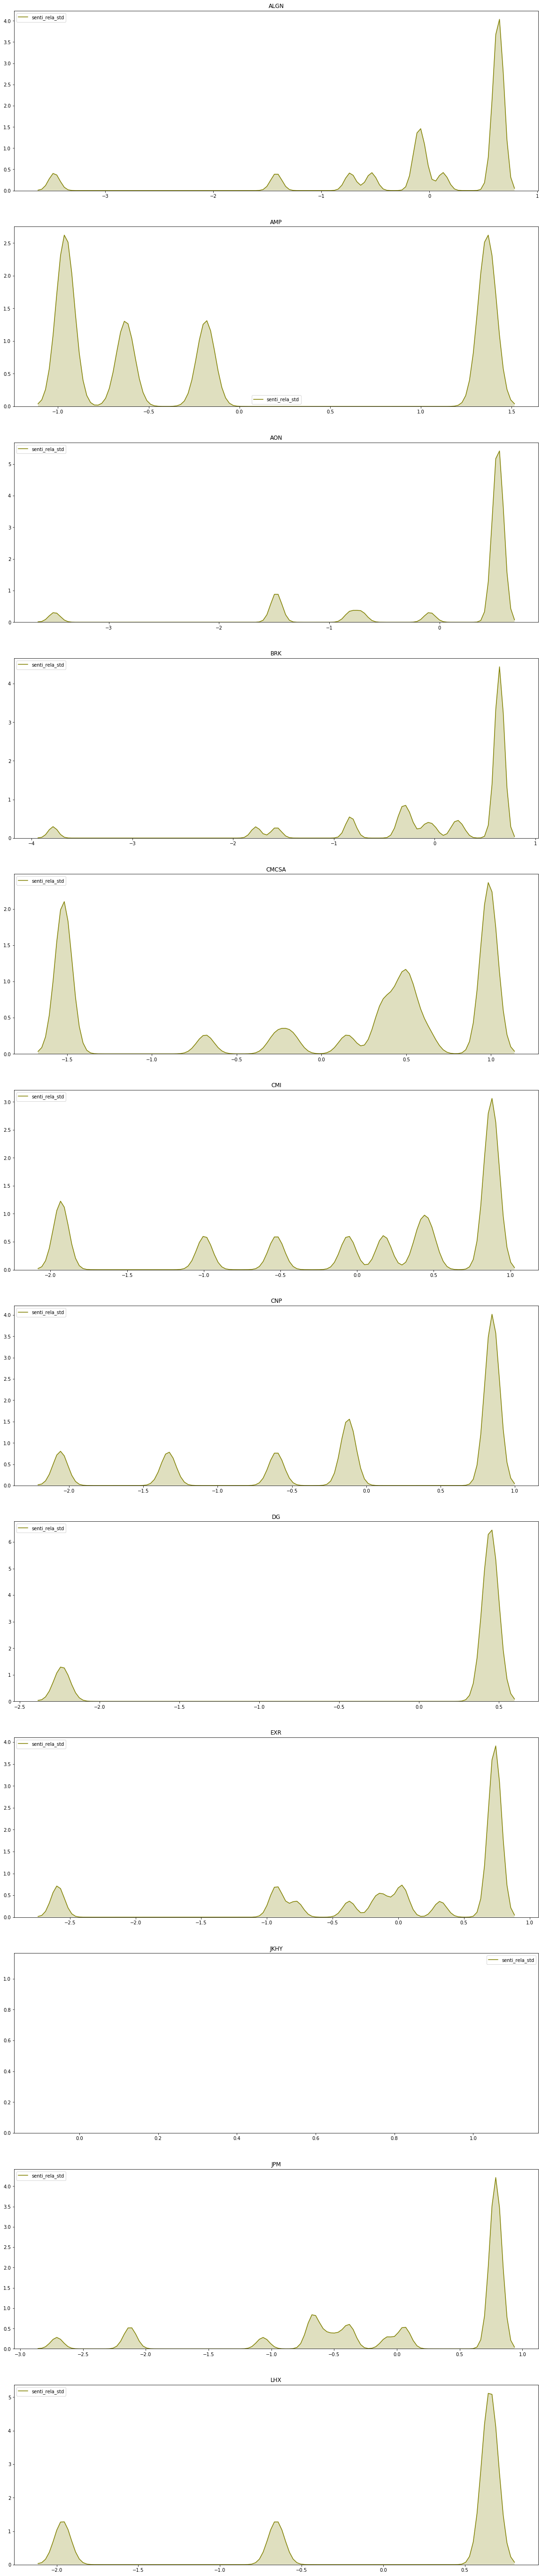

In [46]:
def plot_kernal_sentiment_density(sentiment_data):
    # plot the distribution of sentiment score
    n_company = len(sentiment_data)
    fig, axs = plt.subplots(n_company, figsize=(20,100))
    i = 0
    for company, df in sentiment_data.items():
        sentiment = df['senti_rela_std']
        sns.kdeplot(sentiment, shade=True, 
                    bw=.05, color="olive", ax=axs[i])
        axs[i].set_title(company)
        i += 1

plot_kernal_sentiment_density(sentiment_data)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      excess_log_return   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2.258
Date:                Sun, 13 Dec 2020   Prob (F-statistic):              0.140
Time:                        16:31:36   Log-Likelihood:                 174.10
No. Observations:                  48   AIC:                            -344.2
Df Residuals:                      46   BIC:                            -340.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0021      0.001      1.943      0.058   -7.69e-05       0.004
senti_rela_score    -0.0031      0.002     -1.503      0.140      -0.007       0.001
==============================================================================
Omnibus:                        9.107   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.459
Skew:                           0.846   Prob(JB):                       0.0146
Kurtosis:                       4.169   Cond. No.                         2.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

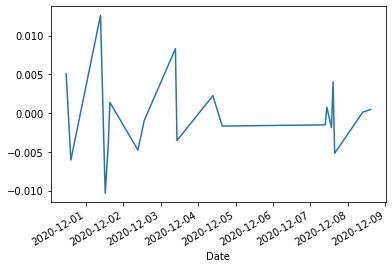

In [38]:
# time series analysis framework
# starts with an example
# y: excess_log_return
# x: senti_rela_score
y = example.loc[:, 'excess_log_return']
x = example.loc[:, 'senti_rela_score']
example = sentiment_data['ALGN']
# plot
# example.loc[:, 'senti_rela_score'].plot()
example.loc[:, 'excess_log_return'].plot()

# simple OLS, no lag
model1 = OLS(y, add_constant(x))
result1 = model1.fit()
result1.summary()

In [47]:
# statistical analysis
# granger causality test
def gc_test(company_name, company_df, response='volume_std'):
    test_array = company_df \
    .loc[:, [response, 'senti_rela_std']]
    
    test_result = grangercausalitytests(test_array, maxlag=1)
    
    return test_result

def gc_test_all(sentiment_data):
    test_result = {}
    
    for name, df in sentiment_data.items():
        print("\n next result \n")

        try:
            r = gc_test(name, df)
            test_result[name] = r
        except ValueError:
            print("Insufficient observations", name)
            test_result[name] = None

test_result = gc_test_all(sentiment_data)


 next result 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3198  , p=0.5801  , df_denom=15, df_num=1
ssr based chi2 test:   chi2=0.3838  , p=0.5356  , df=1
likelihood ratio test: chi2=0.3798  , p=0.5377  , df=1
parameter F test:         F=0.3198  , p=0.5801  , df_denom=15, df_num=1

 next result 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3739  , p=0.3619  , df_denom=2, df_num=1
ssr based chi2 test:   chi2=3.4349  , p=0.0638  , df=1
likelihood ratio test: chi2=2.6147  , p=0.1059  , df=1
parameter F test:         F=1.3739  , p=0.3619  , df_denom=2, df_num=1

 next result 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3907  , p=0.5387  , df_denom=21, df_num=1
ssr based chi2 test:   chi2=0.4465  , p=0.5040  , df=1
likelihood ratio test: chi2=0.4424  , p=0.5060  , df=1
parameter F test:         F=0.3907  , p=0.5387  , df_denom=21, df_num=1

 next result 


Granger Causality
number of lags (no 